In [122]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import KFold
%matplotlib inline

In [113]:
df = pd.read_csv("AmesHousing.tsv",sep = '\t')
df.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour    ...     Pool Area Pool QC  Fence  \
0   NaN       IR1          Lvl    ...             0     NaN    NaN   
1   NaN       Reg          Lvl    ...             0     NaN  MnPrv   
2   NaN       IR1          Lvl    ...             0     NaN    NaN   
3   NaN       Reg          Lvl    ...             0     NaN    NaN   
4   NaN       IR1          Lvl    ...             0     NaN  MnPrv   

  Misc Feature Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0          NaN        0       5    2010       WD           Normal     215000  
1          NaN        0       6    2010       WD           Normal     105000  
2         Gar2    12500       6    2010       WD           Normal     172000  
3          NaN        0       4    2010       WD           Normal     244000  
4          NaN        0       3    2010       WD           Normal     189900  

[5 rows x 82 columns]

In [114]:
def transform_features(df):
    return df

In [115]:
def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

In [116]:
def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    numeric_train = train.select_dtypes(include=['integer','float'])
    numeric_test = test.select_dtypes(include=['integer','float'])
    features = numeric_train.columns.drop('SalePrice')
    lr = LinearRegression()
    lr.fit(numeric_train[features],numeric_train['SalePrice'])
    prediction = lr.predict(numeric_test[features])
    rmse = np.sqrt(mean_squared_error(numeric_test['SalePrice'],prediction))
    return rmse

In [117]:
transform_df = transform_features(df)
select_feature = select_features(transform_df)
rmse = train_and_test(select_feature)
rmse

57088.251612639091

#### Feature Engineering

##### All cols : Removing all columns having 5 per or more missing values

In [7]:
num_missing = df.isnull().sum()
lt_5_cols = num_missing[(num_missing >= len(df)/20)].sort_values()
df = df.drop(lt_5_cols.index, axis=1)

##### Text cols :Removing the text column having one or more missing values.

In [8]:
text_cols = df.select_dtypes(include=['object'])
text_cols_mv = text_cols.isnull().sum()
mv_1 = text_cols_mv[(text_cols_mv > 0)]
df = df.drop(mv_1.index,axis=1)

##### Numerical columns : with missing values fill with most common values

In [ ]:
num_cols = df.select_dtypes(include=['integer','float'])
num_cols_mv = num_cols.isnull().sum()
fixable_num_cols_mv = num_cols_mv[(num_cols_mv <= len(df)/20) & (num_cols_mv > 0)].index
replace_value_dict = df[fixable_num_cols_mv].mode().to_dict(orient='records')[0]
replace_value_dict

In [15]:
df = df.fillna(replace_value_dict)

##### verifying the null values

In [17]:
df.isnull().sum().value_counts()

0    64
dtype: int64

##### Creating new features

In [23]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [25]:
year_since_remod = df['Yr Sold'] - df['Year Remod/Add']
year_since_remod[year_since_remod < 0]


1702   -1
2180   -2
2181   -1
dtype: int64

In [26]:
df['year_since_remod'] = year_since_remod
df['years_sold'] = years_sold

#Removing indexes with negative values

df = df.drop([2180,2181,1702],axis=0)

# No longer need of original columns

df = df.drop(['Yr Sold','Year Remod/Add'],axis=1)

##### Droping columns that are not usefull for ML and leaking information regarding the sale

In [31]:
df = df.drop(['PID','Order'],axis=1)
df = df.drop(['Mo Sold','Yr Sold','Sale Condition','Sale Type'],axis=1)


In [118]:
# Lets update the transfor_features() 
def transform_features(df):
    num_missing = df.isnull().sum()
    lt_5_cols = num_missing[(num_missing >= len(df)/20)].sort_values()
    df = df.drop(lt_5_cols.index, axis=1)
    text_cols = df.select_dtypes(include=['object'])
    text_cols_mv = text_cols.isnull().sum()
    mv_1 = text_cols_mv[(text_cols_mv > 0)]
    df = df.drop(mv_1.index,axis=1)
    num_cols = df.select_dtypes(include=['integer','float'])
    num_cols_mv = num_cols.isnull().sum()
    fixable_num_cols_mv = num_cols_mv[(num_cols_mv <= len(df)/20) & (num_cols_mv > 0)].index
    replace_value_dict = df[fixable_num_cols_mv].mode().to_dict(orient='records')[0]
    df = df.fillna(replace_value_dict)
    years_sold = df['Yr Sold'] - df['Year Built']
    year_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df = df.drop([2180,2181,1702],axis=0)
    df = df.drop(['Yr Sold','Year Remod/Add','PID','Order','Mo Sold','Yr Sold','Sale Condition','Sale Type'],axis=1)
    return df
    


In [119]:
transform_df = transform_features(df)
select_df = select_features(transform_df)
rmse = train_and_test(select_df)
rmse

55275.367312413073

#### Feature Selection

In [120]:
numeric_cols = transform_df.select_dtypes(['integer','float'])
numeric_cols.head()

MS SubClass  Lot Area  Overall Qual  Overall Cond  Year Built  \
0           20     31770             6             5        1960   
1           20     11622             5             6        1961   
2           20     14267             6             6        1958   
3           20     11160             7             5        1968   
4           60     13830             5             5        1997   

   Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
0         112.0         639.0           0.0        441.0         1080.0   
1           0.0         468.0         144.0        270.0          882.0   
2         108.0         923.0           0.0        406.0         1329.0   
3           0.0        1065.0           0.0       1045.0         2110.0   
4           0.0         791.0           0.0        137.0          928.0   

     ...      Garage Cars  Garage Area  Wood Deck SF  Open Porch SF  \
0    ...              2.0        528.0           210             62   
1    ...              1.0        730.0           140              0   
2    ...              1.0        312.0           393             36   
3    ...              2.0        522.0             0              0   
4    ...              2.0        482.0           212             34   

   Enclosed Porch  3Ssn Porch  Screen Porch  Pool Area  Misc Val  SalePrice  
0               0           0             0          0         0     215000  
1               0           0           120          0         0     105000  
2               0           0             0          0     12500     172000  
3               0           0             0          0         0     244000  
4               0           0             0          0         0     189900  

[5 rows x 32 columns]

In [48]:
abs_corr_coeff = numeric_cols.corr()['SalePrice'].abs().sort_values()
abs_corr_coeff


BsmtFin SF 2       0.006127
Misc Val           0.019273
3Ssn Porch         0.032268
Bsmt Half Bath     0.035875
Low Qual Fin SF    0.037629
Pool Area          0.068438
MS SubClass        0.085128
Overall Cond       0.101540
Screen Porch       0.112280
Kitchen AbvGr      0.119760
Enclosed Porch     0.128685
Bedroom AbvGr      0.143916
Bsmt Unf SF        0.182751
Lot Area           0.267520
2nd Flr SF         0.269601
Bsmt Full Bath     0.276258
Half Bath          0.284871
Open Porch SF      0.316262
Wood Deck SF       0.328183
BsmtFin SF 1       0.439284
Fireplaces         0.474831
TotRms AbvGrd      0.498574
Mas Vnr Area       0.506983
Full Bath          0.546118
Year Built         0.558490
1st Flr SF         0.635185
Garage Area        0.641425
Total Bsmt SF      0.644012
Garage Cars        0.648361
Gr Liv Area        0.717596
Overall Qual       0.801206
SalePrice          1.000000
Name: SalePrice, dtype: float64

##### Lets take only those features having correlation coefficent more than 0.4 .

##### And drop the columns having corr coef less that 0.4

In [50]:
transform_df = transform_df.drop(abs_corr_coeff[abs_corr_coeff < 0.4].index,axis=1)

##### Generating the heatmap.

In [54]:
corr_mat = transform_df.corr()

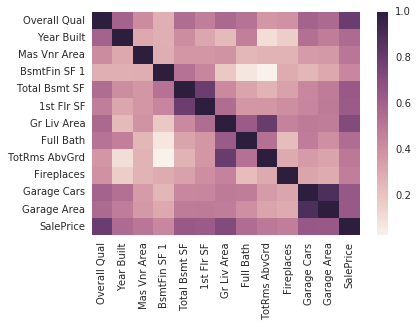

In [55]:
seaborn.heatmap(corr_mat)

##### Creating the list of the features those are meant to be categorical.

In [56]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [58]:
cat_cols_df = []
for col in nominal_features:
    if col in transform_df.columns:
        cat_cols_df.append(col)
cat_cols_df        
        

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

##### Lets check how many unique values are there for these categotical columns.

In [83]:
uniqueness_counts = transform_df[cat_cols_df].apply(lambda x: len(x.value_counts())).sort_values()                                                     
                                                                         
uniqueness_counts

Street           2
Central Air      2
Land Contour     4
Lot Config       5
Bldg Type        5
Roof Style       6
Foundation       6
Heating          6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

##### Lets drop those columns having more than 10 unique values.

In [86]:
cols_to_drop = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(cols_to_drop,axis=1)

In [96]:
cat_cols_df.remove('Exterior 1st')
cat_cols_df.remove('Exterior 2nd')
cat_cols_df.remove('Neighborhood')

###### Lets convert the remaining columns to the category type and adding the dummies columns per category type.
    
    

In [110]:
text_cols = transform_df.select_dtypes(include=['object'])
for elm in text_cols:
    transform_df[elm].astype('category')
    
transform_df = pd.concat([transform_df,pd.get_dummies(text_cols)],axis=1) 




    

###### Now update the select_features function.

In [121]:
def select_features(df,coeff_thres = 0.4,unique_counts_thres=10):
    numeric_cols = transform_df.select_dtypes(['integer','float'])
    abs_corr_coeff = numeric_cols.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeff[abs_corr_coeff < coeff_thres].index,axis=1)
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    cat_cols_df = []
    for col in nominal_features:
        if col in df.columns:
            cat_cols_df.append(col)
    uniqueness_counts = df[cat_cols_df].apply(lambda x: len(x.value_counts())).sort_values()                                                     
    cols_to_drop = uniqueness_counts[uniqueness_counts > unique_counts_thres].index
    df = df.drop(cols_to_drop,axis=1)
    text_cols = df.select_dtypes(include=['object'])
    for elm in text_cols:
        df[elm].astype('category')
    df = pd.concat([df,pd.get_dummies(text_cols)],axis=1) 
    return df

In [133]:
def train_and_test(df,k=0):
    numeric_df = df.select_dtypes(include=['integer','float'])
    features = numeric_df.columns.drop('SalePrice')
    lr = LinearRegression()
    if k==0:
        train = df[:1460]
        test = df[1460:]
        lr.fit(train[features],train['SalePrice'])
        prediction = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test['SalePrice'],prediction))
        return rmse
    if k==1:
        #we need to randomize the index.
        shuf_df = df.sample(frac=1,)
        train = df[:1460]
        test = df[1460:]
        lr.fit(train[features],train['SalePrice'])
        predict_1 = lr.predict(test[features])
        rmse1 = np.sqrt(mean_squared_error(test['SalePrice'],predict_1))
        lr.fit(test[features],test['SalePrice'])
        predict_2 = lr.predict(train[features])
        rmse2 = np.sqrt(mean_squared_error(train['SalePrice'],predict_2))
        return np.mean([rmse1,rmse2])
    else:
        kf = KFold(n_splits=k,shuffle=True)
        rmse_values = []
        for train_index,test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features],train['SalePrice'])
            predictions = lr.predict(test[features])
            rmse = np.sqrt(mean_squared_error(test['SalePrice'],predictions))
            rmse_values.append(rmse)
        return np.mean(rmse_values)    

In [134]:
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df,k=4)
rmse

28882.235704474813